In [1]:
!mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
!ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m

ln: failed to create symbolic link '/aiffel/aiffel/recommendata_iu/data/ml-1m/movies.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/recommendata_iu/data/ml-1m/ratings.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/recommendata_iu/data/ml-1m/README': File exists
ln: failed to create symbolic link '/aiffel/aiffel/recommendata_iu/data/ml-1m/users.dat': File exists


## 1. 데이터 준비하기

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)

ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
ratings = ratings.loc[ratings['rating'] >= 3]
filtered_data_size = len(ratings)

In [5]:
print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


대표적인 explicit 데이터인 별점을 implicit 데이터로 간주하기 위해 시청횟수로 해석하고 이에 따른 변화를 구현해줍니다.

In [6]:
ratings.rename(columns={'rating':'count'}, inplace=True)

In [7]:
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

시간에 대한 컬럼인 'timestamp' 컬럼은 필요하지 않으므로 삭제합니다.

In [8]:
del ratings['timestamp']

In [9]:
ratings.head()

,user_id,movie_id,count
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


동일한 'movie_id'를 기준으로 제목과 장르가 기록된 데이터도 가져옵니다.

In [10]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Exploring the data

간단하게 데이터를 분석해보겠습니다.
1. How many users are there?
2. How many movies are there?
3. How many genres are there?
4. What is the most watched movie?
5. Who watched the movie the most?
6. What is the favorite movie?
7. What is the mean ratings per genre?

### (1) Users, Movies, Genres

In [11]:
print(f"There are {ratings['user_id'].nunique()} users.")

There are 6039 users.


In [12]:
print(f"There are {ratings['movie_id'].nunique()} movies.")

There are 3628 movies.


In [13]:
print(f"There are {movies['genre'].nunique()} genres. (without refined classification)")

There are 301 genres. (without refined classification)


### (2) The most watched movie, user who watched the most.

In [14]:
movie_count = ratings.groupby('movie_id')['user_id'].count()
movie_count = movie_count.sort_values(ascending=False)
movie_count = pd.DataFrame({'movie_id': movie_count.index, 'count':movie_count.to_numpy()})

In [15]:
most_movie_id = movie_count['movie_id'].iloc[0]
most_movie_count = movie_count['count'].iloc[0]

df_temp = movies.loc[movies["movie_id"] == most_movie_id]

display(df_temp)

print(f">>> The most watched movie is {df_temp['title'].iloc[0]}")
print(f"for {most_movie_count} times.")

,movie_id,title,genre
2789,2858,American Beauty (1999),Comedy|Drama


>>> The most watched movie is American Beauty (1999)
for 3211 times.


In [17]:
mv_count = movie_count['count'].value_counts().sort_values(ascending=False)
mv_count

1       119
2        88
3        63
4        51
8        42
       ... 
1029      1
741       1
2498      1
1027      1
2019      1
Name: count, Length: 836, dtype: int64

In [18]:
## HOW TO MAKE seaborn palette to colormap ##

# import matplotlib as mpl
# from matplotlib.colors import ListedColormap
# colors = sns.color_palette("Blues", n_colors=2000)
# my_cmap = ListedColormap(colors.as_hex())

Text(0.5, 0, 'How many times each movie was watched')

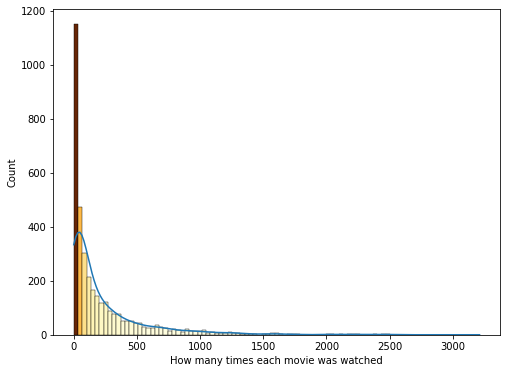

In [20]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=movie_count['count'], ax=ax, kde=True)

heights = [p.get_height() for p in ax.patches] ## 각 값(막대의 높이) 구하기
h_min, h_max = min(heights), max(heights)
cmap_ = 'YlOrBr'
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    p.set_facecolor(cmap(h_norm))
    
ax.set_xlabel("How many times each movie was watched")

In [21]:
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count = user_count.sort_values(ascending=False)
user_count = pd.DataFrame({'user_id': user_count.index, 'count':user_count.to_numpy()})

display(user_count)

print(f">>> User id {user_count.loc[0, 'user_id']} watched {user_count.loc[0, 'count']} movies.")

,user_id,count
0,4169,1968
1,4277,1715
2,1680,1515
3,3618,1146
4,1015,1145
...,...,...
6034,4636,9
6035,1102,9
6036,4056,9
6037,4349,7


>>> User id 4169 watched 1968 movies.


In [22]:
us_count = user_count['count'].value_counts().sort_values(ascending=False)

In [23]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
colors = sns.color_palette("Greens", n_colors=2000)
my_cmap = ListedColormap(colors.as_hex())


Text(0.5, 0, 'How many times each user watched')

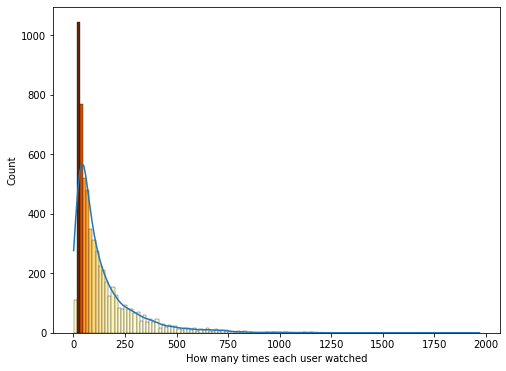

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data=user_count['count'], ax=ax, kde=True)

heights = [p.get_height() for p in ax.patches] ## 각 값(막대의 높이) 구하기
h_min, h_max = min(heights), max(heights)
cmap_ = 'YlOrBr'
cmap = cm.get_cmap(cmap_)

for p in ax.patches:
    h_norm = (p.get_height() - h_min) / (h_max - h_min)
    p.set_facecolor(cmap(h_norm))
ax.set_xlabel("How many times each user watched")

### Favorite movie, rating per genre.

In [25]:
avg_watch = ratings.groupby('movie_id')['count'].mean()
avg_watch = avg_watch.sort_values(ascending=False)
avg_watch = pd.DataFrame({'movie_id': avg_watch.index, 'count':avg_watch.to_numpy()})

display(avg_watch)

most_avg_id = avg_watch.loc[0, 'movie_id']
most_avg_title = movies.loc[movies["movie_id"] == most_avg_id]['title'].iloc[0]

print(f">>> Movie id {most_avg_title} is watched {avg_watch.loc[0, 'count']} score for average.")


,movie_id,count
0,1830,5.0
1,3607,5.0
2,3800,5.0
3,3280,5.0
4,989,5.0
...,...,...
3623,821,3.0
3624,3876,3.0
3625,2214,3.0
3626,1532,3.0


>>> Movie id Follow the Bitch (1998) is watched 5.0 score for average.


실제로는 해당영화는 1번만 봤다고 나온 영화이기 때문에 실제 가장 좋아하는 영화라고 보기 어렵습니다. 따라서 실제 본 횟수를 'count', 평점의 의미를 가진 count를 'rating_count'로 바꿔보겠습니다. (기존에 rating이였지만 앞쪽에서 count로 변경한 부분.)

In [26]:
avg_watch = avg_watch.rename(columns={"count": "rating_count"})

그리고 실제 본 횟수와 rating이였던 count를 모두 가지고 있는 데이터를 만들고, 이 데이터를 통해 250번 이상 실제로 본 영화중에 rating_count가 가장 높은 영화를 뽑아보겠습니다.

In [27]:
total_df = pd.merge(movie_count, avg_watch, how='inner', on='movie_id')
total_df.head()

,movie_id,count,rating_count
0,2858,3211,4.499844
1,260,2910,4.528522
2,1196,2885,4.384055
3,1210,2716,4.161635
4,2028,2561,4.431082


In [28]:
temp_df = movies[['movie_id', 'genre', 'title']]
total_df = pd.merge(total_df, temp_df, on='movie_id')

total_df.head()

,movie_id,count,rating_count,genre,title
0,2858,3211,4.499844,Comedy|Drama,American Beauty (1999)
1,260,2910,4.528522,Action|Adventure|Fantasy|Sci-Fi,Star Wars: Episode IV - A New Hope (1977)
2,1196,2885,4.384055,Action|Adventure|Drama|Sci-Fi|War,Star Wars: Episode V - The Empire Strikes Back...
3,1210,2716,4.161635,Action|Adventure|Romance|Sci-Fi|War,Star Wars: Episode VI - Return of the Jedi (1983)
4,2028,2561,4.431082,Action|Drama|War,Saving Private Ryan (1998)


In [29]:
temp_df = total_df.loc[total_df['count'] >= 250]

avg_watch = temp_df.groupby('movie_id')['rating_count'].mean()
avg_watch = avg_watch.sort_values(ascending=False)
avg_watch = pd.DataFrame({'movie_id': avg_watch.index, 'rating_count':avg_watch.to_numpy()})

display(avg_watch)

most_avg_id = avg_watch.loc[0, 'movie_id']
most_avg_title = movies.loc[movies["movie_id"] == most_avg_id]['title'].iloc[0]

print(f">>> Movie id {most_avg_title} is watched {avg_watch.loc[0, 'rating_count']:.3f} rating_count for average.")



,movie_id,rating_count
0,2019,4.629690
1,858,4.598523
2,318,4.596627
3,50,4.577982
4,527,4.571112
...,...,...
1005,2054,3.420624
1006,2616,3.370968
1007,673,3.362229
1008,2701,3.360119


>>> Movie id Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) is watched 4.630 rating_count for average.


이제 가장 높은 rating_count를 받은 장르에 대해 뽑아보겠습니다. 장르가 여러개인 영화를 별도로 분류하지 않았습니다. 

장르를 나누기 위해서는 Comedy|Drama|Western의 경우 각각 개별적인 장르에 똑같은 rating_count를 가진 형태로 만들어줄 수도 있지만, 실제로는 서부 드라마 형식을 띈 코미디를 좋아하는 것이지 각각 세 가지 요소를 개별적으로 좋아하는 것은 아니기 때문에 의미가 희석될 수도 있을 것 같고 구현에 시간이 꽤 오래 걸릴 것 같아 이번 과정에서는 하지 않았습니다.

In [30]:
genre_count = total_df.groupby('genre')['rating_count'].mean()
genre_count = genre_count.sort_values(ascending=False)
genre_count = pd.DataFrame({'genre': genre_count.index, 'avg count':genre_count.to_numpy()})

display(genre_count.head())


print(f">>> Genre {genre_count.loc[0, 'genre']} get {genre_count.loc[0, 'avg count']:.3f} for average.")

,genre,avg count
0,Comedy|Drama|Western,4.549936
1,Sci-Fi|War,4.539334
2,Film-Noir|Mystery,4.407452
3,Action|Adventure|Drama|Sci-Fi|War,4.384055
4,Film-Noir|Sci-Fi,4.383856


>>> Genre Comedy|Drama|Western get 4.550 for average.


## Initial user profile setting for model validation

In [31]:
total_df = total_df[['movie_id', 'title', 'genre', 'rating_count', 'count']]

Since it is more intuitive to show 'title' than 'movie_id', I choose to make new dataframe.

'movie_id'보다는 'title'을 직접 사용하는 것이 조금 더 직관적이기 때문에 새로운 데이터를 만들어주겠습니다.

In [32]:
data = pd.merge(ratings, total_df, on='movie_id') 
data = data[['user_id', 'title', 'count_x']]
data.rename(columns={'count_x': 'count'}, inplace=True)
data

,user_id,title,count
0,1,One Flew Over the Cuckoo's Nest (1975),5
1,2,One Flew Over the Cuckoo's Nest (1975),5
2,12,One Flew Over the Cuckoo's Nest (1975),4
3,15,One Flew Over the Cuckoo's Nest (1975),4
4,17,One Flew Over the Cuckoo's Nest (1975),5
...,...,...,...
836473,5851,One Little Indian (1973),5
836474,5854,Slaughterhouse (1987),4
836475,5854,"Promise, The (Versprechen, Das) (1994)",3
836476,5938,"Five Wives, Three Secretaries and Me (1998)",4


Keep the years in the paratheses.

영화제목안의 괄호는 그대로 살려뒀습니다. 추후에 인덱싱을 해줄 것이기도 하고 같은 영화제목이 있다면 연도로 표기해주는 것이 맞는 것 같아 그대로 뒀습니다.

제가 좋아하는 영화를 5개 꼽아 정보로 넣어주겠습니다.

In [33]:
my_favorite = ['American Beauty (1999)', 'Men in Black (1997)', 'Groundhog Day (1993)', 'Toy Story (1995)', 'Fight Club (1999)']

my_watchlist = pd.DataFrame({'user_id': ['sunwoong']*5, 'title':my_favorite, 'count':[5, 5, 4, 4, 4]})

if not data.isin({'user_id':['sunwoong']})['user_id'].any():
    data = data.append(my_watchlist)

data.tail(10)

,user_id,title,count
836473,5851,One Little Indian (1973),5
836474,5854,Slaughterhouse (1987),4
836475,5854,"Promise, The (Versprechen, Das) (1994)",3
836476,5938,"Five Wives, Three Secretaries and Me (1998)",4
836477,5948,Identification of a Woman (Identificazione di ...,5
0,sunwoong,American Beauty (1999),5
1,sunwoong,Men in Black (1997),5
2,sunwoong,Groundhog Day (1993),4
3,sunwoong,Toy Story (1995),4
4,sunwoong,Fight Club (1999),4


## Preprocessing

### Indexing

In [34]:
user_unique = data['user_id'].unique()
title_unique = data['title'].unique()

user_to_idx = {v: k for k, v in enumerate(user_unique)}
title_to_idx = {v: k for k, v in enumerate(title_unique)}

idx_to_user = {v: k for k, v in user_to_idx.items()}
idx_to_title = {v: k for k, v in title_to_idx.items()}

In [35]:
print(len(user_unique))
print(len(title_unique))

6040
3628


In [36]:
print(user_to_idx['sunwoong'])
print(title_to_idx['American Beauty (1999)'])

6039
99


In [37]:
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data
else:
    print('user id column indexing Fail!!')

user_id column indexing OK!!


In [38]:
temp_title_data = data['title'].map(title_to_idx.get).dropna()
if len(temp_user_data) == len(data):
    print('title column indexing OK!!')
    data['title'] = temp_title_data
else:
    print('title id column indexing Fail!!')

title column indexing OK!!


In [39]:
data

,user_id,title,count
0,0,0,5
1,1,0,5
2,2,0,4
3,3,0,4
4,4,0,5
...,...,...,...
0,6039,99,5
1,6039,175,5
2,6039,110,4
3,6039,40,4


In [40]:
from scipy.sparse import csr_matrix
import numpy as np

num_user = data['user_id'].nunique()
num_title = data['title'].nunique()

csr_data = csr_matrix((data['count'], (data['user_id'], data['title'])), shape= (num_user, num_title))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [41]:
from implicit.als import AlternatingLeastSquares

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [42]:
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, use_gpu=False, iterations=50, dtype=np.float32)

In [43]:
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [44]:
als_model.fit(csr_data_transpose)

  0%|          | 0/50 [00:00<?, ?it/s]

제가 미리 좋아한다고 넣어둔 아메리칸 뷰티를 얼마나 추천해줄 지 확인해보겠습니다.

In [45]:
sunwoong, American_Beauty = user_to_idx['sunwoong'], title_to_idx['American Beauty (1999)']
sunwoong_vector, American_Beauty_vector = als_model.user_factors[sunwoong], als_model.item_factors[American_Beauty]

In [46]:
np.dot(sunwoong_vector, American_Beauty_vector)

0.85337526

블레이드 러너의 경우 그다지 추천하지 않는 영화로 나왔습니다.

In [47]:
Blade_Runner = title_to_idx['Blade Runner (1982)']
Blade_Runner_vector = als_model.item_factors[Blade_Runner]
np.dot(sunwoong_vector, Blade_Runner_vector)

-0.03942136

이번엔 비슷한 영화를 찾아주는 함수를 만들어보겠습니다.

In [48]:
def get_similar_title(movie_title: str):
    title_id = title_to_idx[movie_title]
    similar_title = als_model.similar_items(title_id)
    similar_title = [idx_to_title[i[0]] for i in similar_title]
    return similar_title

In [49]:
get_similar_title('Blade Runner (1982)')

['Blade Runner (1982)',
 'Aliens (1986)',
 'Brazil (1985)',
 'Terminator, The (1984)',
 'Chinatown (1974)',
 'Running Free (2000)',
 'Alien (1979)',
 'Time Bandits (1981)',
 'Mina Tannenbaum (1994)',
 'Jeanne and the Perfect Guy (Jeanne et le garçon formidable) (1998)']

In [50]:
get_similar_title('Jaws (1975)')

['Jaws (1975)',
 'Alien (1979)',
 'Jaws 2 (1978)',
 'Exorcist, The (1973)',
 'Rocky (1976)',
 'Carrie (1976)',
 'Shining, The (1980)',
 'Butch Cassidy and the Sundance Kid (1969)',
 'Halloween (1978)',
 'Goldfinger (1964)']

In [51]:
get_similar_title('Titanic (1997)')

['Titanic (1997)',
 'Gay Deceivers, The (1969)',
 'Held Up (2000)',
 'Walking Dead, The (1995)',
 'Snow Day (2000)',
 'Aiqing wansui (1994)',
 'Paris, France (1993)',
 'Soft Toilet Seats (1999)',
 'Killer Shrews, The (1959)',
 'Simon Sez (1999)']

최종적으로 저에게 추천해주는 영화들을 살펴보겠습니다.

In [52]:
user = user_to_idx['sunwoong']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
[idx_to_title[i[0]] for i in movie_recommended]

['Toy Story 2 (1999)',
 'Being John Malkovich (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Jurassic Park (1993)',
 'Galaxy Quest (1999)',
 'Forrest Gump (1994)',
 'Matrix, The (1999)',
 'Shakespeare in Love (1998)',
 'Babe (1995)',
 "Bug's Life, A (1998)",
 'Election (1999)',
 'Austin Powers: International Man of Mystery (1997)',
 'Nightmare Before Christmas, The (1993)',
 'Get Shorty (1995)',
 "There's Something About Mary (1998)",
 "One Flew Over the Cuckoo's Nest (1975)",
 'Back to the Future (1985)',
 'Strictly Ballroom (1992)',
 'Insider, The (1999)',
 'Total Recall (1990)']

## Recommendation by genre.

영화를 title 별로 추천받지 않고 장르별로 추천을 받을 수도 있겠다는 생각이 들어 장르별로 추천을 받을 수 있도록 구현해봤습니다. 데이터 구성만 바꿨을 뿐, 위 과정과 동일합니다.

여기서도 장르가 여러개인 영화를 나눠주지는 않았습니다.

In [53]:
data = pd.merge(ratings, total_df, on='movie_id') 
data = data[['user_id', 'genre', 'count_x']]
data.rename(columns={'count_x': 'count'}, inplace=True)
data

,user_id,genre,count
0,1,Drama,5
1,2,Drama,5
2,12,Drama,4
3,15,Drama,4
4,17,Drama,5
...,...,...,...
836473,5851,Comedy|Drama|Western,5
836474,5854,Horror,4
836475,5854,Romance,3
836476,5938,Documentary,4


In [54]:
my_favorite = ['Action|Comedy', 'Drama|Thriller', 'Comedy|Drama|Thriller', 'Comedy', 'Crime|Thriller']

my_watchlist = pd.DataFrame({'user_id': ['sunwoong']*5, 'genre':my_favorite, 'count':[4, 5, 3, 3, 5]})

if not data.isin({'user_id':['sunwoong']})['user_id'].any():
    data = data.append(my_watchlist)

data.tail(10)

,user_id,genre,count
836473,5851,Comedy|Drama|Western,5
836474,5854,Horror,4
836475,5854,Romance,3
836476,5938,Documentary,4
836477,5948,Drama,5
0,sunwoong,Action|Comedy,4
1,sunwoong,Drama|Thriller,5
2,sunwoong,Comedy|Drama|Thriller,3
3,sunwoong,Comedy,3
4,sunwoong,Crime|Thriller,5


## Preprocessing

### Indexing

In [55]:
user_unique = data['user_id'].unique()
genre_unique = data['genre'].unique()

user_to_idx = {v: k for k, v in enumerate(user_unique)}
genre_to_idx = {v: k for k, v in enumerate(genre_unique)}

idx_to_user = {v: k for k, v in user_to_idx.items()}
idx_to_genre = {v: k for k, v in genre_to_idx.items()}

In [56]:
print(len(user_unique))
print(len(genre_unique))

6040
301


In [57]:
print(user_to_idx['sunwoong'])
print(genre_to_idx['Action|Comedy'])

6039
71


In [58]:
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data
else:
    print('user id column indexing Fail!!')

user_id column indexing OK!!


In [59]:
temp_genre_data = data['genre'].map(genre_to_idx.get).dropna()
if len(temp_user_data) == len(data):
    print('genre column indexing OK!!')
    data['genre'] = temp_genre_data
else:
    print('genre id column indexing Fail!!')

genre column indexing OK!!


In [60]:
from scipy.sparse import csr_matrix
import numpy as np

num_user = data['user_id'].nunique()
num_genre = data['genre'].nunique()

csr_data = csr_matrix((data['count'], (data['user_id'], data['genre'])), shape= (num_user, num_genre))
csr_data

<6040x301 sparse matrix of type '<class 'numpy.longlong'>'
	with 313152 stored elements in Compressed Sparse Row format>

In [61]:
from implicit.als import AlternatingLeastSquares

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [62]:
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, use_gpu=False, iterations=75, dtype=np.float32)

In [63]:
csr_data_transpose = csr_data.T
csr_data_transpose

<301x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 313152 stored elements in Compressed Sparse Column format>

In [64]:
als_model.fit(csr_data_transpose)

  0%|          | 0/75 [00:00<?, ?it/s]

In [65]:
sunwoong, crime_drama = user_to_idx['sunwoong'], genre_to_idx['Crime|Drama']
sunwoong_vector, crime_drama_vector = als_model.user_factors[sunwoong], als_model.item_factors[crime_drama]

범죄드라마 장르, 그리고 스릴러를 얼마나 추천할 지 확인해보겠습니다.

In [66]:
np.dot(sunwoong_vector, crime_drama_vector)

-0.009363241

In [67]:
Thriller = genre_to_idx['Thriller']
Thriller_vector = als_model.item_factors[Thriller]
np.dot(sunwoong_vector, Thriller_vector)

0.023057714

In [68]:
def get_similar_genre(movie_genre: str):
    genre_id = genre_to_idx[movie_genre]
    similar_genre = als_model.similar_items(genre_id)
    similar_genre = [idx_to_genre[i[0]] for i in similar_genre]
    return similar_genre

In [69]:
get_similar_genre('Drama|Thriller')

['Drama|Thriller',
 'Drama',
 'Comedy',
 'Comedy|Drama',
 'Drama|Romance',
 'Thriller',
 'Drama|War',
 'Action|Thriller',
 'Crime|Drama',
 'Comedy|Romance']

어떤 이유인지 추가적으로 살펴봐야겠지만, 'Comedy'가 꽤 높이 랭크해있습니다. 단순하게 생각해보면 그 뒤로는 Drama와 Thriller중 한 장르는 들어가는 것들이 나와 꽤 믿을 수 있을 것 같지만 'Comedy'가 높은 위치에 랭크해있는 것은 의외였습니다.

Drama|Thriller를 좋아하는 사람들의 많은 비율이 Drama를 좋아하고, Drama를 좋아하는 사람들 중 많은 비율로 Comedy를 좋아하기 때문이 아닐까 싶습니다.

In [70]:
get_similar_genre('Drama')

['Drama',
 'Comedy',
 'Comedy|Drama',
 'Comedy|Romance',
 'Drama|Romance',
 'Drama|Thriller',
 'Thriller',
 'Action|Thriller',
 'Action|Drama|War',
 'Drama|War']

In [71]:
get_similar_genre('Horror')

['Horror',
 'Thriller',
 'Horror|Thriller',
 'Comedy',
 'Drama',
 'Action|Thriller',
 'Comedy|Drama',
 'Comedy|Romance',
 'Comedy|Horror|Sci-Fi',
 'Crime|Thriller']

마지막으로 장르별로 추천을 받아보겠습니다.

In [72]:
user = user_to_idx['sunwoong']
# recommend에서는 user*item CSR Matrix를 받습니다.
genre_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
[idx_to_genre[i[0]] for i in genre_recommended]

['Comedy|Crime|Horror',
 'Adventure|Comedy|Romance',
 'Action|Adventure|Comedy',
 'Comedy|Horror|Thriller',
 'Romance|Thriller',
 'Mystery',
 'Adventure|Fantasy',
 'Action|Adventure|Romance|War',
 'Crime|Drama|Mystery|Thriller',
 'Adventure|Thriller',
 'Action|Adventure|Animation',
 'War',
 'Drama|Mystery|Romance',
 'Action|Drama|Western',
 'Action|Comedy|Drama',
 'Crime|Film-Noir|Mystery',
 'Horror|Mystery|Thriller',
 'Action|Comedy|Musical|Sci-Fi',
 'Comedy|Thriller',
 'Drama|Fantasy|Romance|Thriller']

## 소감

우선 추천시스템 자체의 적용은 아주 재밌고 좋았습니다. 수희 퍼실님이 진행하셨던 상영회에서 네이버의 추천시스템을 봤다고 합니다. 해당 영상에서 이 정도 수준의 추천시스템은 기초적인 수준이라고 얘기를 했다고 전달해주셨습니다. 

원리 자체도 Feature들 간의 내적으로 추천을 해주는 방식이였습니다. 그래도 꽤나 좋은 추천을 받을 수 있었는데, 실제로 추천시스템의 구현은 어떤식으로 이뤄지고 어떠한 방식이 있는 지 좀 더 살펴보고 싶어졌습니다.

추가적으로 시각화 과정에서 바의 높이에 따라 색을 입히고 싶었는데 예전에 알았던 내용인데 다시 해보려니 오래 걸렸습니다. 이런 걸 미리미리 정리를 해놔야 시간낭비없이 쓸 수 있을 것 같습니다.

이번 주말에는 추천해준 영화나 장르로 영화나 한편 봐야겠어요.